<a href="https://colab.research.google.com/github/mickeykubo/fastai-v1/blob/master/fastai_training_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Google Colab を用いた fast.ai による深層学習

Copyright Mikio Kubo@LOGOPT


まずはインストールを行う．

1. 上部メニューのランタイム/ランタイプの種類を変更でGPUをオンにする．
2. GPUにあったPyTorchをpipで入れる．（pytorchのホームページで，GPU，Cudaを調べて，pipコマンドを生成）
3. torchvisionを入れる．
4. fastaiを入れる．
5. 画像モジュールにバグがあるので，Pillowをダウングレードする．

簡単に言うと，以下のセルに移動してShift+Enter（もしくは；ipadとかだと実行ボタン）を押す．

In [1]:
!pip3 install https://download.pytorch.org/whl/cu80/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install fastai
!pip3 install Pillow==4.1.1
# fast.ai が準備した以下のコマンドだと1行でいける．
# 注意：Google Colabの環境が変わる可能性がある．
# !curl https://course-v3.fast.ai/setup/colab | bash

    100% |████████████████████████████████| 532.5MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5eca0000 @  0x7ff0885e52a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 2.0MB 12.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.
    100% |████████████████████████████████| 163kB 6.9MB/s 
    100% |████████████████████████████████| 112kB 31.3MB/s 
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad4551

 fastaiのユーティリティにある show_install関数でインストールの状態を確認しておく．

また，check_perf()関数で，環境の改善点を示唆してもらっておく．

Pillowについて文句を言っているようだが，バグがあるうちは仕方ない．

In [0]:
 from fastai.utils.collect_env import *
 show_install(True)



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.39
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 396.44
torch cuda    : 8.0.61 / is available
torch cudnn   : 7102 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Fri Jan 11 20:46:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+---------

In [0]:
check_perf()

Running performance checks.

*** libjpeg-turbo status
❓ libjpeg-turbo's status can't be derived - need Pillow(-SIMD)? >= 5.4.0 to tell, current version 4.1.1

*** Pillow-SIMD status
✘ Running Pillow 4.1.1; It's recommended you install Pillow-SIMD to speed up image resizing and other operations. See https://docs.fast.ai/performance.html#pillow-simd

*** CUDA status
✘ You are running pytorch built against cuda 8.0.61, your NVIDIA driver 396.44 supports cuda10. See https://pytorch.org/get-started/locally/ to install pytorch built against the faster CUDA version.

Refer to https://docs.fast.ai/performance.html to make sense out of these checks and suggestions.


CPUとGPUの時間を比較してみる．

In [0]:
import torch
t_cpu = torch.rand(50,50,50)
%timeit t_cpu @ t_cpu

1000 loops, best of 3: 343 µs per loop


In [0]:
t_gpu = torch.rand(50,50,50).cuda()
%timeit t_gpu @ t_gpu

The slowest run took 4.26 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 38.5 µs per loop


# 訓練モジュール

まずは必要なモジュールをインポートする．


In [0]:
from fastai import *
from fastai.vision import *

## MNIST_SIMPLE の訓練

深層学習の"Hello World"に相当するMNISTの小規模サンプル（３と７だけのデータ）を用いて，訓練のコツを伝授する．

MNIST_SIMPLE のデータを読み込む．

In [0]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

In [0]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (12396 items)
[Category 7, Category 7, Category 7, Category 7, Category 7]...
Path: /root/.fastai/data/mnist_sample
x: ImageItemList (12396 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: /root/.fastai/data/mnist_sample;

Valid: LabelList
y: CategoryList (2038 items)
[Category 7, Category 7, Category 7, Category 7, Category 7]...
Path: /root/.fastai/data/mnist_sample
x: ImageItemList (2038 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: /root/.fastai/data/mnist_sample;

Test: None

読み込んだデータの1バッチ分は show_batchメソッドでみることができる．引数のfigsizeで大きさを調整する．

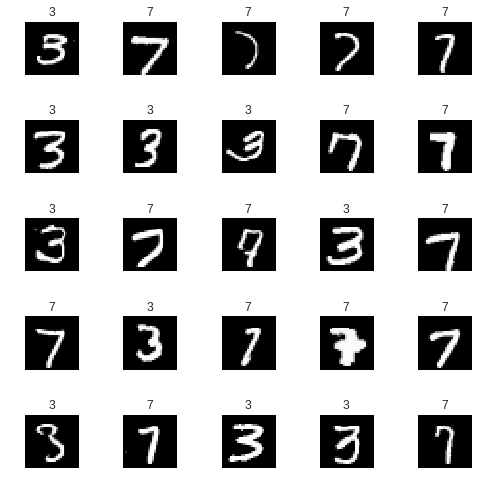

In [0]:
data.show_batch(figsize=(7,7))

単純なcnn（畳み込みニューラルネット）モデル modelのインスタンスを生成し，データとあわせて学習器 learn を生成する．メトリクスは精度(accuracy)を指定しておく

In [0]:
model = simple_cnn((3,16,16,2))
learn = Learner(data,model,metrics=[accuracy])

In [0]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (12396 items)
[Category 7, Category 7, Category 7, Category 7, Category 7]...
Path: /root/.fastai/data/mnist_sample
x: ImageItemList (12396 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: /root/.fastai/data/mnist_sample;

Valid: LabelList
y: CategoryList (2038 items)
[Category 7, Category 7, Category 7, Category 7, Category 7]...
Path: /root/.fastai/data/mnist_sample
x: ImageItemList (2038 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: /root/.fastai/data/mnist_sample;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (2): Sequential(
    (0): Conv

深層学習で最も重要なパラメータは，学習率(learning rate: lrと略される）である．深層学習とは，重み調整のために非線形最適化をいいかげんに行うだけの反復法であり，要は勾配に適当なステップサイズを乗じて現在の値から減じる操作を繰り返す．この非線形最適化におけるステップサイズのことを，学習率と呼んでいるだけなのだ．

これをチューニングするために，fastaiでは学習器オブジェクト にlr_find() というメソッドを準備している．

学習器learnを作成してlearn.lr_find() をした後に，learn.recorder.plot()とする

In [0]:
learn.lr_find() 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


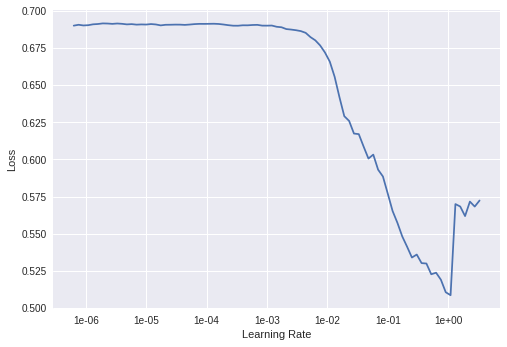

In [0]:
learn.recorder.plot()

これは学習率を小さな値から1反復ごとに2倍にしたときの損出関数（目的関数のこと）をプロットしたものだ．実際の反復ごとの学習率は，learn.recorder.plot_lr()とうつと見ることができる．

損出関数が最小になるのは，学習率が1e+0 あたりだが，これより多少小さな値が良いと言われている．ここでは，学習率を1e-1(0.1)に設定して訓練してみる．

これには学習器インスタンスのfitメソッドを用いる．引数はエポック数と学習率である．

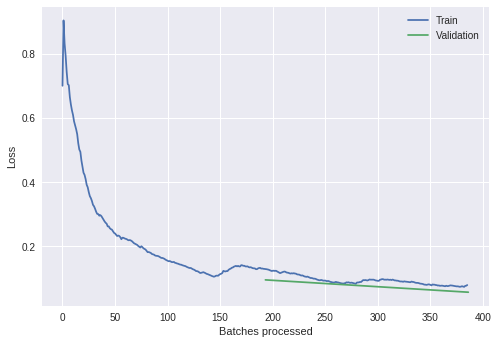

In [0]:
learn.fit(2,0.1)
learn.recorder.plot_losses()

学習率を変化させながら訓練を行う fit_one_cycleを用いてみよう．

引数はエポック数と最大学習率 max_lr である．

In [0]:
learn.fit_one_cycle(3,max_lr=1e-2)

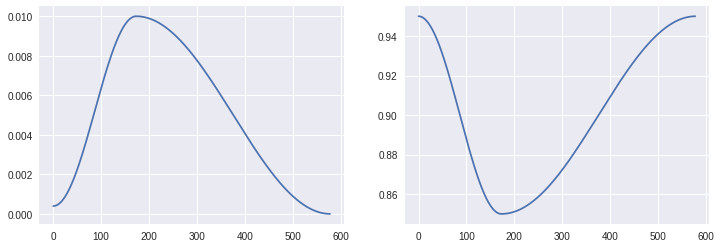

In [0]:
learn.recorder.plot_lr(True)

この方法では，学習率を小さな値から最大学習率まで増やし，その後徐々に減少させていく．同時に，モメンタム（慣性項）を徐々に下げて，その後増加させていく．

実際にどのように変化させているかは，recorder.plot_lrで確認することができる．

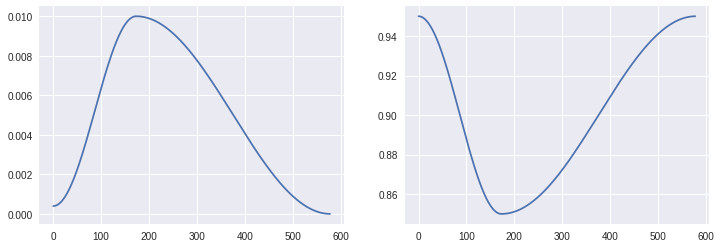

In [0]:
learn.recorder.plot_lr(show_moms=True)

精度は98%まで改善された．損出関数の変化をプロットしてみよう．

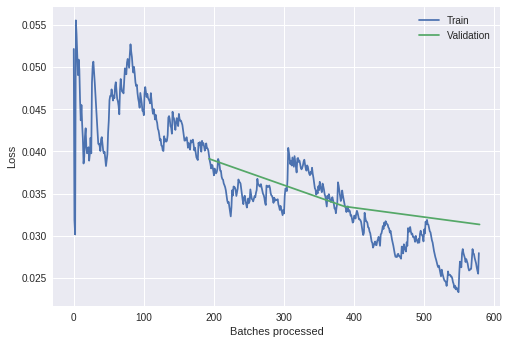

In [0]:
learn.recorder.plot_losses()

損出関数の値と予測値を得るには，get_predsメソッドを用いる．

元のデータと予測値，正解（y），損出関数の値を引数として， ClassificationInterpretation()クラスのインスタンスを生成する．

plot_top_lossesを用いると，損出関数が悪かったデータを描画してくれる．

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)

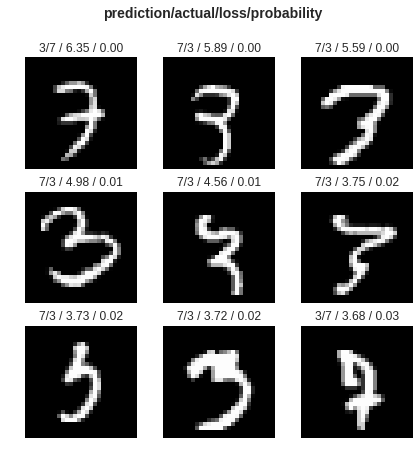

In [0]:
interp.plot_top_losses(9, figsize=(7,7))

正解と外れを表す表（混合行列とよばれる）を出力するには，polt_confusion_matrixを使う．

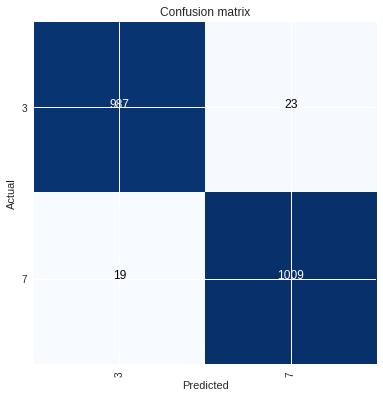

In [0]:
interp.plot_confusion_matrix()

単純cnnでなく，resnetを使ってみよう．これは残差ネットワークとよばれ， learn.summaryをみると，大規模な畳み込みニューラルネットであることが分かる．学習済みの重みが読み込まれ，この重みをもとに転移学習を行う．

In [0]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 27666644.14it/s]


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


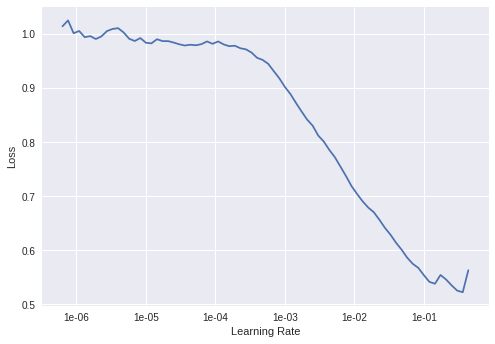

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1,max_lr=1e-2)

unfreeze()メソッドによって，resnetの学習済みの重み層を，自由に変更できるようにし，fit_one_cycleですべての層の重みを訓練してみる．学習率は，最初の方の層では，最終層と比べて小さめに設定しておくと良い．

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3,max_lr=slice(1e-5,1e-4,1e-3) )

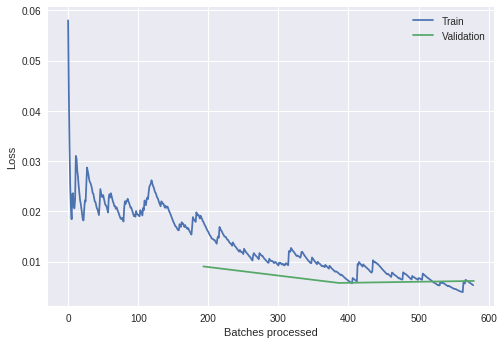

In [0]:
learn.recorder.plot_losses()

損出関数の値が悪かった9つのデータを表示して，混合行列を出力する．

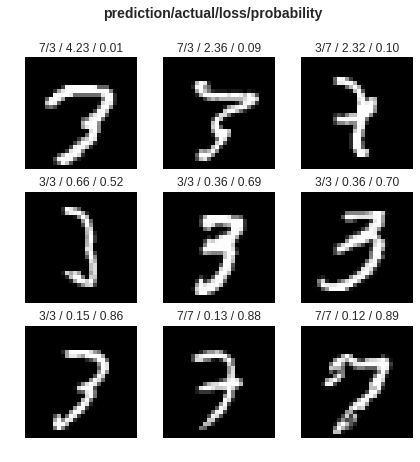

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)
interp.plot_top_losses(9, figsize=(7,7))

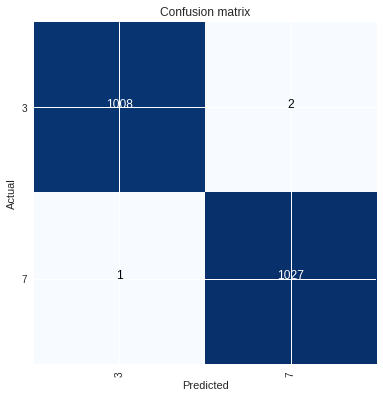

In [0]:
interp.plot_confusion_matrix()

## ＭＮＩＳＴ の訓練

0-9の数字の画像ファイルから，数字を当てる．

ファイルをダウンロードしたて展開したときのフォルダ名が間違えてるのでリネームする．

In [0]:
path = untar_data(URLs.MNIST)


In [0]:
!mv {path}/testing {path}/valid
!mv {path}/training {path}/train
!ls {path}

train  valid


In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms)
data.normalize()

ImageDataBunch;

Train: LabelList
y: CategoryList (60000 items)
[Category 1, Category 1, Category 1, Category 1, Category 1]...
Path: /root/.fastai/data/mnist_png
x: ImageItemList (60000 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Valid: LabelList
y: CategoryList (10000 items)
[Category 1, Category 1, Category 1, Category 1, Category 1]...
Path: /root/.fastai/data/mnist_png
x: ImageItemList (10000 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
learn = Learner(data, models.Darknet(num_blocks=[1,2,8,8,4],num_classes=10),metrics=accuracy).to_fp16()
learn.fit_one_cycle(10, wd=0.4)

## Cifar10の訓練

Cifar10は粗い画像から，10種類の物体を当てる問題である．

データを読み込んだ後に，get_ransform()でデータ増大(data augmentation)を行うためのオブジェクトtfms を生成する．

画像データ束クラス ImageDatabunch のfrom_forder()メソッドでデータを生成するが，
その際に引数df_tfmsにtfmsを渡して訓練時に画像を多少変えて行うように設定する．

最後に，データ束をnormalize()メソッドで正規化して，表示する．

In [0]:
path = untar_data(URLs.CIFAR)

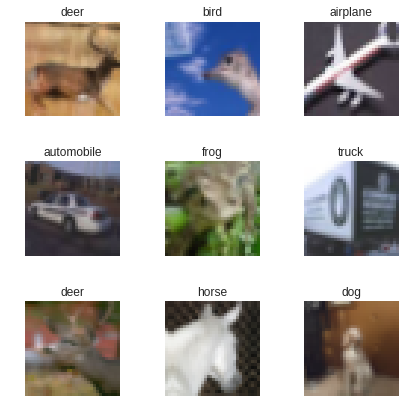

In [0]:
tfms = get_transforms()
#tfms = ([pad(padding=4), crop(size=32, row_pct=(0,1), col_pct=(0,1)), flip_lr(p=0.5)], [])
data = ImageDataBunch.from_folder(path, valid='test',ds_tfms=tfms)
#data.normalize()
data.normalize(cifar_stats)
data.show_batch(rows=3, figsize=(6,6))

データとアーキテクチャ（モデル：今回はワイド残差ネットワーク）をあわせて学習器を生成する．

メトリクスは精度(accuracy)とする．

また，to_fp16()メソッドで混合精度（floating point を32ビットでなく16ビットで計算する)
ようにする．

訓練はfit_one_cycleを用いる．エポック数は30とし，過剰適合を避けるために，重み減衰のパラメータwdは0.4と大きめに設定する．

In [0]:
learn = Learner(data, models.wrn_22(), metrics=accuracy).to_fp16()
learn.fit_one_cycle(30, wd=0.4)

Buffered data was truncated after reaching the output size limit.

In [0]:
learn.recorder.plot_losses()

外れているデータをみてから，混合行列を出力する．

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)
interp.plot_top_losses(9, figsize=(7,7))

In [0]:
interp.plot_confusion_matrix()

## PETSの訓練

37種類のPETの種類を判別する．

データの読み込みには正規表現を用いる．

モデル（アーキテキクチャ）は画像ファイルなのでRESNETを用いる．

In [0]:
path = untar_data(URLs.PETS)
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
path_anno = path/"annotations"
path_img = path/"images"

In [0]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/samoyed_173.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_89.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_91.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_60.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_43.jpg')]

上のファイル名から，"Russian_Blue"などのクラス名だけを抽出するための正規表現を準備する．

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

ImageDataBunchクラスのfrom_name_re()メソッドは，正規表現を用いてデータを生成する．
引数は順に，
* 画像ファイルの置き場所
* ファイル名のリスト
* クラス名をファイル名から抽出するための正規表現
* データ増大のための関数
* 画像ファイルのサイズ
である．

その後で，imagenet_stats（イメージネットの統計量）をもとに正規化する．

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (5912 items)
[Category samoyed, Category Russian_Blue, Category wheaten_terrier, Category boxer, Category Bombay]...
Path: /root/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (5912 items)
[Image (3, 334, 500), Image (3, 500, 428), Image (3, 500, 387), Image (3, 441, 500), Image (3, 500, 415)]...
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList
y: CategoryList (1478 items)
[Category Sphynx, Category great_pyrenees, Category german_shorthaired, Category miniature_pinscher, Category basset_hound]...
Path: /root/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (1478 items)
[Image (3, 500, 332), Image (3, 453, 500), Image (3, 500, 357), Image (3, 333, 500), Image (3, 333, 500)]...
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

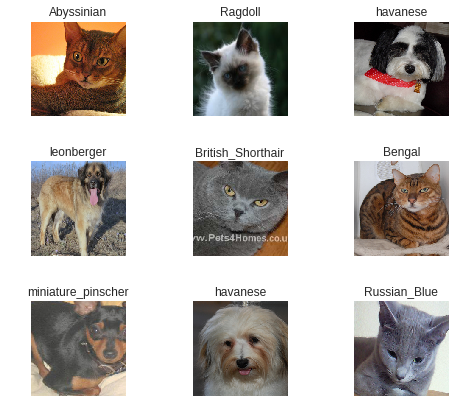

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4)

## DOGS & CATの訓練

画像ファイルから犬か猫からを判別する．

使用するモデル（アーキテキクチャ）はRESNET34

In [0]:
# dogs and cats example code 
path = untar_data(URLs.DOGS)

data = ImageDataBunch.from_folder(
    path, 
    ds_tfms=get_transforms(), 
    size=224
 )


In [0]:
learn = create_cnn(data, models.resnet34, metrics=[accuracy]).to_fp16()
learn.fit(1)

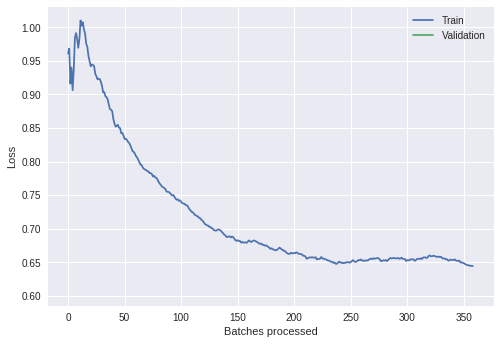

In [0]:
learn.recorder.plot_losses()

# 表形式データの学習


In [0]:
from fastai import *

In [0]:
from fastai.tabular import * 

ADULT_SAMPLEは，小規模な表形式データであり，$50k以上の収入があるかどうかを当てるのが目的だ．

In [0]:
path = untar_data(URLs.ADULT_SAMPLE)

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/adult_sample/models'),
 PosixPath('/root/.fastai/data/adult_sample/adult.csv'),
 PosixPath('/root/.fastai/data/adult_sample/export.pkl')]

In [0]:
df = pd.read_csv(path/'adult.csv')
df.head()

age          workclass  fnlwgt     education  education-num  \
0   49            Private  101320    Assoc-acdm           12.0   
1   44            Private  236746       Masters           14.0   
2   38            Private   96185       HS-grad            NaN   
3   38       Self-emp-inc  112847   Prof-school           15.0   
4   42   Self-emp-not-inc   82297       7th-8th            NaN   

        marital-status        occupation    relationship                 race  \
0   Married-civ-spouse               NaN            Wife                White   
1             Divorced   Exec-managerial   Not-in-family                White   
2             Divorced               NaN       Unmarried                Black   
3   Married-civ-spouse    Prof-specialty         Husband   Asian-Pac-Islander   
4   Married-civ-spouse     Other-service            Wife                Black   

       sex  capital-gain  capital-loss  hours-per-week  native-country salary  
0   Female             0          1902              40   United-States  >=50k  
1     Male         10520             0              45   United-States  >=50k  
2   Female             0             0              32   United-States   <50k  
3     Male             0             0              40   United-States  >=50k  
4   Female             0             0              50   United-States   <50k

表形式データの基本クラスは TabularDataBunch であり，これはfrom_dfメソッドを用いてpandasのデータフレームから作ることができる．

主な引数の意味は以下の通り．

- path：ファイルの置き場所
- df: データフレーム
- dep_var: 従属変数の列名
- valid_idx: 検証用データのインデックス
- proc: 前処理の方法を入れたリスト
- cat_names: カテゴリーデータの列名のリスト
- cont_names: 連続量データの列名のリスト

前処理には以下のものがある．

- Categorify(cat_names:StrList, cont_names:StrList)

cat_namesに含まれる列をカテゴリー変数とする．

- FillMissing(cat_names:StrList, cont_names:StrList, 
fill_strategy:FillStrategy=<FillStrategy.MEDIAN: 1>, 
add_col:bool=True, fill_val:float=0.0) 

cont_namesに含まれる連続変数に対して欠損値処理を行う．
`FillStrategy`には[MEDIAN, COMMON, CONSTANT]があり，順にメディアン，最頻値，定数（fill_valで指定）である．また，add_colがTrueのときには，欠損値であることを表す列を追加する．

- Normalize(cat_names:StrList, cont_names:StrList) 

連続変数の正規化を行う．(平均を引いて標準偏差+微少量で割る．）

他に以下の時刻型の列を自動的に幾つかのカテゴリー変数に変換する関数が準備されている．

```
add_datepart(df, fldname, drop=True, time=False)
```

fldnameは時刻型が含まれている列名であり，dropがTrueのとき元の列を削除する．またtimeがTrueのときには，日付だけでなく時，分，秒の列も追加する．

In [0]:
procs = [FillMissing, Categorify, Normalize] #前処理の種類を準備．
valid_idx = range(len(df)-2000, len(df)) #検証用データのインデックスを準備．
dep_var = 'salary' #従属変数名とカテゴリー変数が格納されている列リストを準備．
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [0]:
# DataBunchのインスタンスdataを生成．
data = TabularDataBunch.from_df(path, df, dep_var, 
valid_idx=valid_idx, procs=procs, cat_names=cat_names)

さて，TabularDataBunch クラスのfrom_dfメソッドでDataBunchオブジェクトを作成したら，以下の関数で表形式データの深層学習器を作ることができる．

```
tabular_learner(data:DataBunch, layers:Collection[int], 
emb_szs:Dict[str, int]=None, metrics=None, ps:Collection[float]=None,
 emb_drop:float=0.0, y_range:OptRange=None, use_bn:bool=True, kwargs)
 ```
 
主な引数の意味は以下の通り．
- data: DataBunch
- layers: レイヤの数を指定したリスト
- emb_szs: カテゴリーデータの列名をキー，埋め込みサイズを値とした辞書
- metrics: 評価尺度(accuracyなど）
- emb_drop: 埋め込みレイヤのdrop out率

In [0]:
#深層学習(PyTorch)の学習器インスタンスlearnを生成し，fitメソッドで訓練．引数はエポック数と学習率．
learn = tabular_learner(data, layers=[200,100], emb_szs={'native-country': 10}, metrics=accuracy)
learn.fit_one_cycle(1, 1e-2)

In [0]:
learn.fit_one_cycle(3,1e-3)

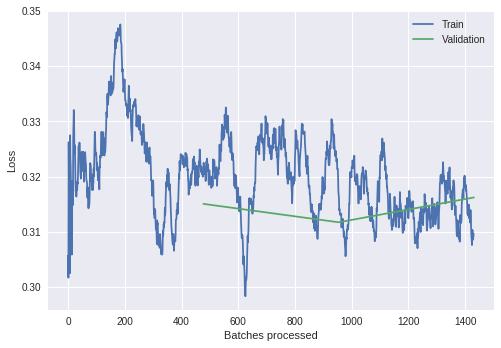

In [0]:
learn.recorder.plot_losses()

summary属性をみると，学習器は，埋め込み層に続いて2つの線形層を配置したニューラルネットになっていることが確認できる．

In [0]:
learn.summary

<bound method model_summary of Learner(data=TabularDataBunch;

Train: LabelList
y: CategoryList (30561 items)
[Category >=50k, Category >=50k, Category <50k, Category >=50k, Category <50k]...
Path: /root/.fastai/data/adult_sample
x: TabularList (30561 items)
[TabularLine workclass  Private; education  Assoc-acdm; marital-status  Married-civ-spouse; occupation #na#; relationship  Wife; race  White; sex  Female; native-country  United-States; education-num_na False; capital-gain -0.1459; age 0.7598; hours-per-week -0.0358; capital-loss 4.5067; education-num 0.7539; fnlwgt -0.8371; , TabularLine workclass  Private; education  Masters; marital-status  Divorced; occupation  Exec-managerial; relationship  Not-in-family; race  White; sex  Male; native-country  United-States; education-num_na False; capital-gain 1.2670; age 0.3937; hours-per-week 0.3682; capital-loss -0.2168; education-num 1.5376; fnlwgt 0.4449; , TabularLine workclass  Private; education  HS-grad; marital-status  Divorced; oc

In [4]:
boston = pd.read_csv('http://logopt.com/data/Boston.csv',index_col=0)
boston.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
1  396.90   4.98  24.0  
2  396.90   9.14  21.6  
3  392.83   4.03  34.7  
4  394.63   2.94  33.4  
5  396.90   5.33  36.2

In [0]:
procs = [FillMissing, Normalize] #前処理の種類を準備．
valid_idx = range(int(len(boston)*0.7), len(boston)) #検証用データのインデックスを準備．
dep_var = 'medv' #従属変数名とカテゴリー変数が格納されている列リストを準備．
cat_names = []

In [0]:
# DataBunchのインスタンスdataを生成．
data = TabularDataBunch.from_df(path="",df=boston, dep_var=dep_var,valid_idx=valid_idx)

In [8]:
#深層学習(PyTorch)の学習器インスタンスlearnを生成し，fitメソッドで訓練．引数はエポック数と学習率．
learn = tabular_learner(data, layers=[200,100])
learn.fit_one_cycle(5, 1e-2)

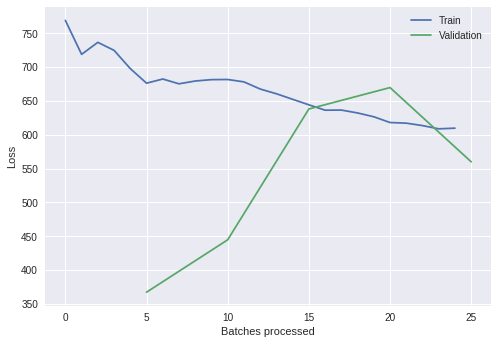

In [9]:
learn.recorder.plot_losses()

# 画像データの例

In [0]:
from fastai.vision import *

## 衛星画像から複数のラベルを生成する問題


PLANET_TYNYデータよ読み込み，画像をデータ増大(data augmentation)を用いて水増ししておく．

In [0]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
data = (ImageItemList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        .random_split_by_pct()
        .label_from_df(sep=' ')
        .transform(planet_tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

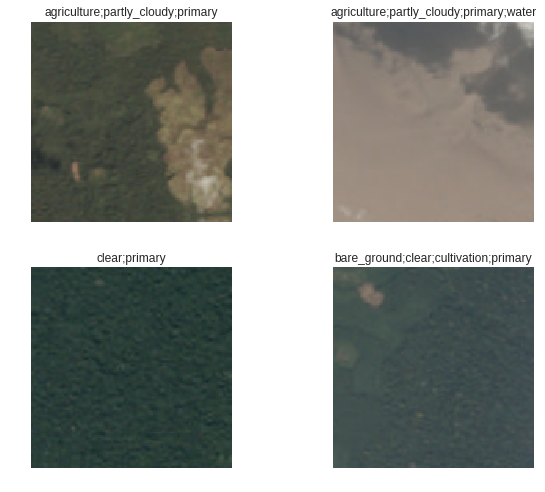

In [0]:
data.show_batch(rows=2, figsize=(9,7))

In [0]:
learn = create_cnn(data, models.resnet18)
learn.fit_one_cycle(5,1e-2)

結果の表示

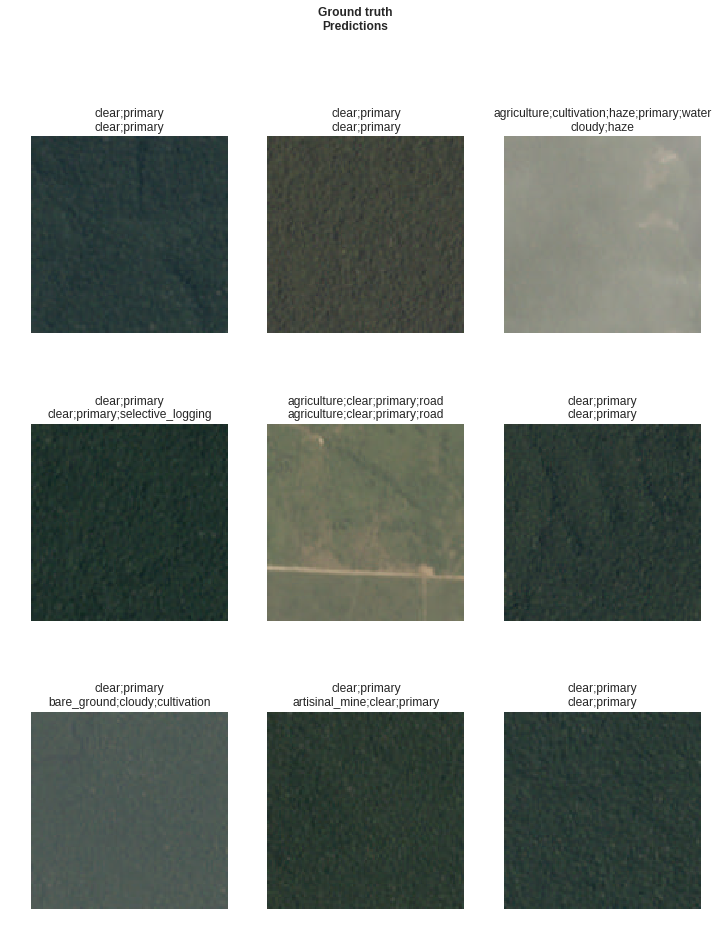

In [0]:
learn.show_results(rows=3, figsize=(12,15))

# 画像から人の頭の中心を当てる回帰

データを読み込み，サンプル画像を表示

In [0]:
biwi = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = pickle.load(open(biwi/'centers.pkl', 'rb'))

In [0]:
data = (PointsItemList.from_folder(biwi)
        .random_split_by_pct(seed=42)
        .label_from_func(lambda o:fn2ctr[o.name])
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch()
        .normalize(imagenet_stats))

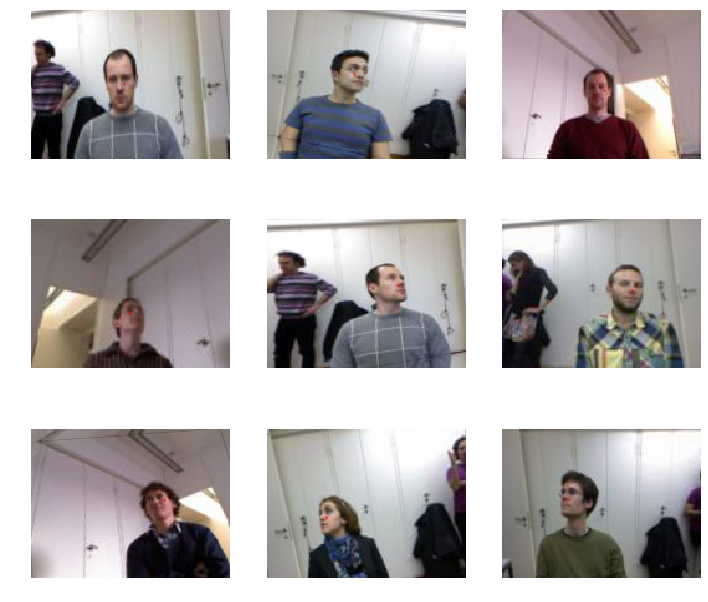

In [0]:
data.show_batch(rows=3, figsize=(10,9))

In [0]:
learn = create_cnn(data, models.resnet18, lin_ftrs=[100], ps=0.05)
learn.fit_one_cycle(5, 5e-2)

正解と予測を表示

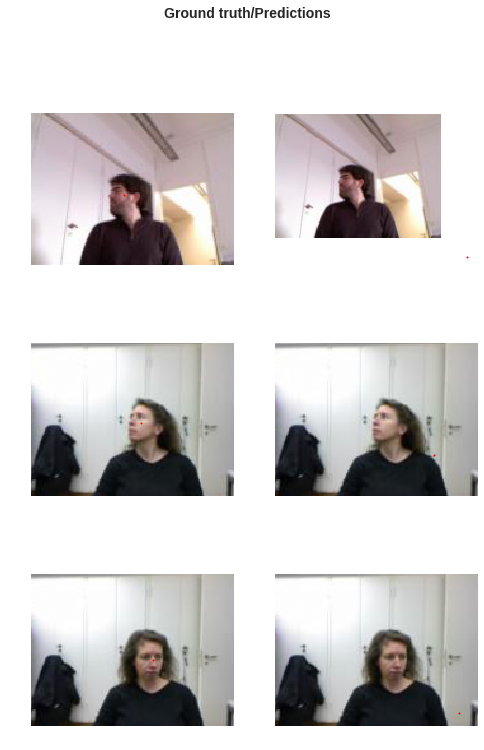

In [0]:
learn.show_results(rows=3)

# 協調フィルタリングの例

In [0]:
from fastai.collab import * 

協調フィルタリング(collaborative filtering)とは，推奨システム(recommender system)の一種で，ユーザーとアイテムの両方の潜在因子を考慮して，レーティングを決める手法だ．

推奨システムでよく見かけるのは，「この商品を買った人はこの商品も買っています」とか「最も良く売れているのはこの商品です」などの猿でもできるタイプのものだ．このような単純なものではなく，あなたに似た潜在因子をもつ人が，高いレーティングをつけている（もしくは良く購入する）商品に近い潜在因子をもった商品を紹介するのが，協調フィルタリングである．

機械学習の中で（Andrew Ngが実務家から聞いた話だが）実務で最も役に立つ，もしくは期待されているのがこれだ．

有名な例題（映画の評価値を当てる）であるMovieLensのデータを読み込む．

データにはtimestamp列がついているが，とりあえずこれは無視してレーティング(rating)を予測してみる．

In [0]:
path = untar_data(URLs.ML_SAMPLE)
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

userId  movieId  rating   timestamp
0      73     1097     4.0  1255504951
1     561      924     3.5  1172695223
2     157      260     3.5  1291598691
3     358     1210     5.0   957481884
4     130      316     2.0  1138999234

CollabDataBunchクラスのfrom_dfメソッドにデータフレームを入れるとデータオブジェクトを作成してくれる．

引数はデータフレーム(ratings)，検証データの比率(pct_val)，ユーザー，アイテム，レーティングを表す列名だ．

In [0]:
data = CollabDataBunch.from_df(ratings)

作成したデータオブジェクトをcollab_learner関数に入れると学習器（誤差を最小にする潜在因子行列の重みの最適化が目的）を作ってくれる．予測したいレーティングは，星５つまでなので，y_rangeで指定する．

データオブジェクト(data)，潜在因子の数(n_factors)を指定しているが，他にもmetricsは評価尺度，wdはweight decayで正規化のためのパラメータなどを指定できる．

```
def collab_learner(data, n_factors:int=None, use_nn:bool=False, metrics=None,
                  emb_szs:Dict[str,int]=None, wd:float=0.01, **kwargs)->Learner
 ```

In [0]:
learn = collab_learner(data, n_factors=50, y_range=(0.,5.))

In [0]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)